In [1]:
import numpy
import math
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import wilcoxon
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import tensorflow as tf

In [2]:
#Read in day wise AQI and calculate mean monthly AQI values
data = pandas.read_csv('../Aim 3 and 4/prominent.csv')
cities = ['Bengaluru']
month=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

In [3]:
for city in cities:
    temp = data.loc[data['City'] == city]
    if(not temp.empty):
        train = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        test = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        for i in range(2016,2020):
            for j in range(1,13):
                count=0
                aqisum=0
                prominent = {}
                for k in range(1,32):
                    date = str(i)+'-'+str("%02d" % j)+'-'+str("%02d" % k)
                    record = temp.loc[temp['Date'] == date]
                    if(not record.empty):
                        if(not math.isnan(record['AQI'])):
                            aqisum = aqisum + record.iloc[0]['AQI']
                            count = count + 1
                            pollutants = record['AQI_label'].to_string()
                            pollutants = pollutants.replace('\'','')
                            pollutants = pollutants.split('(', 1)[-1]
                            pollutants = pollutants.split(')', 1)[0]
                            for pollutant in pollutants.split(','):
                                if(str(pollutant) in prominent):
                                    prominent[str(pollutant)]=prominent[pollutant]+1
                                
                                elif(str(pollutant) != ''):
                                    prominent[str(pollutant)]=0
                                
                            
                        
                    
                
                if(prominent):
                    mark = max(prominent, key=prominent.get)

                else:
                    mark = ''
                
                if(count <= 15):
                    mean=float('NaN')
                
                else:
                    mean=float(aqisum/count)
                
                if(i == 2019):
                    test = test.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                
                else:
                    train = train.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                
            
        
    


<AxesSubplot:>

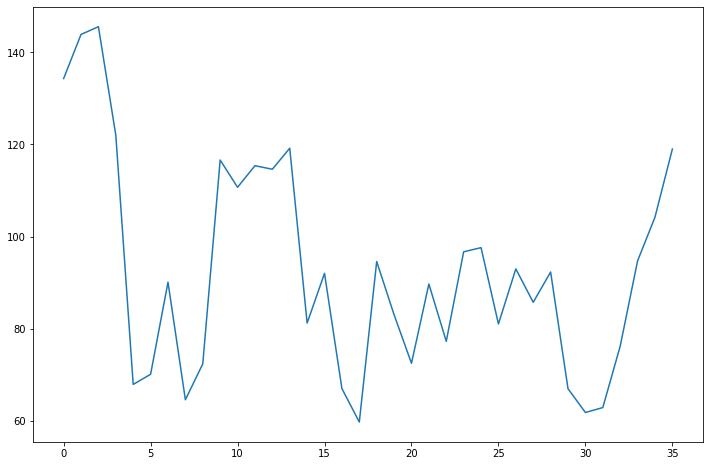

In [4]:
#Interpolate AQI data over 2016, 2017 and 2018
train['Mean'] = train['Mean'].interpolate()
test['Mean'] = test['Mean'].interpolate()
train['Mean'].plot(figsize=(12,8))

Text(0, 0.5, 'AQI')

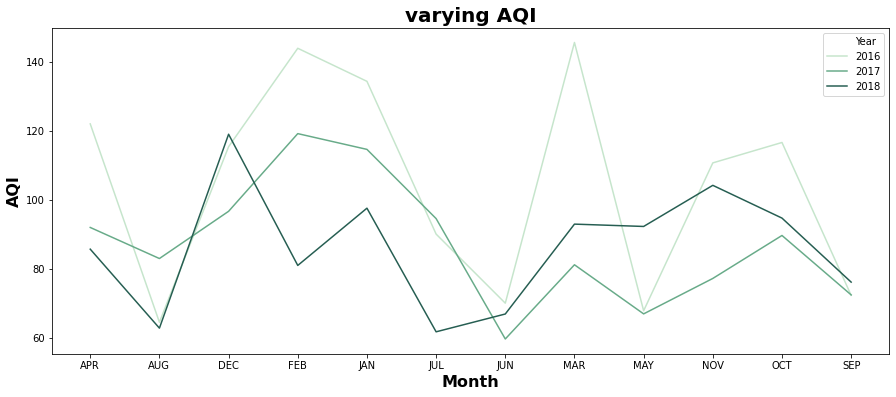

In [5]:
#Plot the seasonal plot for AQI across 2016, 2017 and 2018
variable = 'salinitySurface'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 3)
sns.lineplot(train['Month'], train['Mean'], hue=train['Year'], palette=palette)
ax.set_title('varying AQI', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'AQI')

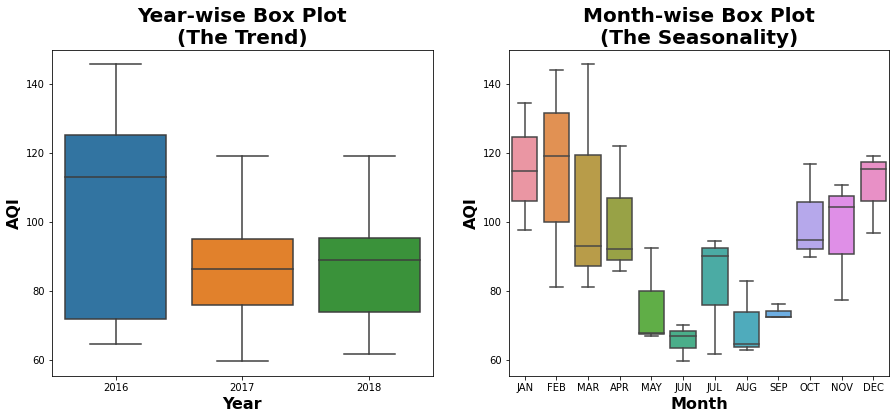

In [6]:
#Plot the year-wise and Month-wise box plot to visualize trend and seasonality
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(train['Year'], train['Mean'], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(train['Month'], train['Mean'], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

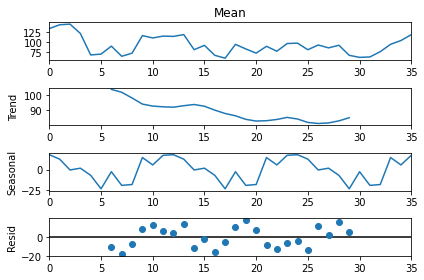

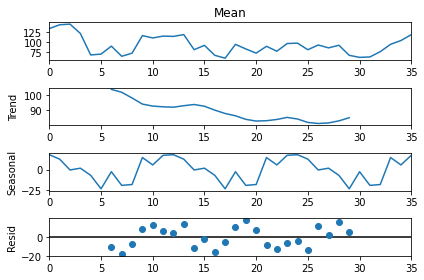

In [7]:
#Decompose time series data into trend, seasonality and residual
res = seasonal_decompose(train['Mean'], model='additive', period=12)
res.plot()

In [8]:
#Check if data is stationary based on ADF statistic
signi = adfuller(train['Mean'])
print('ADF Statistic: %f' % signi[0])
print('p-value: %f' % signi[1])
print('Critical Values:')
for key, value in signi[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.703053
p-value: 0.000083
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


In [9]:
train
li_val = list(train['Mean'])

In [10]:
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		end_ix = i + n_features
		if end_ix > len(timeseries_data)-1:
			break
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return numpy.array(X), numpy.array(y)

In [11]:
timeseries_data = li_val
n_steps = 5
X, y = prepare_data(timeseries_data, n_steps)

In [12]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [13]:
numpy.random.seed(80)
tf.random.set_seed(80)
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=1400, verbose=1)

Epoch 1/1400
1/1 [==============================] - 0s 2ms/step - loss: 8056.5503
Epoch 2/1400
1/1 [==============================] - 0s 9ms/step - loss: 7377.6006
Epoch 3/1400
1/1 [==============================] - 0s 7ms/step - loss: 6761.0132
Epoch 4/1400
1/1 [==============================] - 0s 2ms/step - loss: 6173.6821
Epoch 5/1400
1/1 [==============================] - 0s 2ms/step - loss: 5586.6006
Epoch 6/1400
1/1 [==============================] - 0s 2ms/step - loss: 4972.6851
Epoch 7/1400
1/1 [==============================] - 0s 3ms/step - loss: 4312.1567
Epoch 8/1400
1/1 [==============================] - 0s 3ms/step - loss: 3594.9436
Epoch 9/1400
1/1 [==============================] - 0s 2ms/step - loss: 2837.0161
Epoch 10/1400
1/1 [==============================] - 0s 2ms/step - loss: 2065.2231
Epoch 11/1400
1/1 [==============================] - 0s 2ms/step - loss: 1331.7474
Epoch 12/1400
1/1 [==============================] - 0s 2ms/step - loss: 852.6575
Epoch 13/1400


1/1 [==============================] - 0s 3ms/step - loss: 44.5745
Epoch 102/1400
1/1 [==============================] - 0s 2ms/step - loss: 38.0094
Epoch 103/1400
1/1 [==============================] - 0s 4ms/step - loss: 42.5335
Epoch 104/1400
1/1 [==============================] - 0s 3ms/step - loss: 36.7658
Epoch 105/1400
1/1 [==============================] - 0s 3ms/step - loss: 40.0183
Epoch 106/1400
1/1 [==============================] - 0s 2ms/step - loss: 35.4361
Epoch 107/1400
1/1 [==============================] - 0s 2ms/step - loss: 37.7019
Epoch 108/1400
1/1 [==============================] - 0s 3ms/step - loss: 34.7123
Epoch 109/1400
1/1 [==============================] - 0s 2ms/step - loss: 35.1388
Epoch 110/1400
1/1 [==============================] - 0s 2ms/step - loss: 34.1600
Epoch 111/1400
1/1 [==============================] - 0s 2ms/step - loss: 32.4893
Epoch 112/1400
1/1 [==============================] - 0s 2ms/step - loss: 33.7343
Epoch 113/1400
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.5334
Epoch 202/1400
1/1 [==============================] - 0s 6ms/step - loss: 0.5550
Epoch 203/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.5744
Epoch 204/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.6180
Epoch 205/1400
1/1 [==============================] - 0s 3ms/step - loss: 0.7485
Epoch 206/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.9612
Epoch 207/1400
1/1 [==============================] - 0s 5ms/step - loss: 1.5627
Epoch 208/1400
1/1 [==============================] - 0s 3ms/step - loss: 2.1932
Epoch 209/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.3187
Epoch 210/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.7067
Epoch 211/1400
1/1 [==============================] - 0s 4ms/step - loss: 3.2420
Epoch 212/1400
1/1 [==============================] - 0s 3ms/step - loss: 1.4482
Epoch 213/1400
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.4092
Epoch 303/1400
1/1 [==============================] - 0s 3ms/step - loss: 0.0739
Epoch 304/1400
1/1 [==============================] - 0s 3ms/step - loss: 0.0754
Epoch 305/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.3070
Epoch 306/1400
1/1 [==============================] - 0s 3ms/step - loss: 0.3573
Epoch 307/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.1667
Epoch 308/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 309/1400
1/1 [==============================] - 0s 4ms/step - loss: 0.1100
Epoch 310/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.2305
Epoch 311/1400
1/1 [==============================] - 0s 6ms/step - loss: 0.1725
Epoch 312/1400
1/1 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 313/1400
1/1 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 314/1400
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 0.1767
Epoch 402/1400
1/1 [==============================] - 0s 5ms/step - loss: 0.2924
Epoch 403/1400
1/1 [==============================] - 0s 3ms/step - loss: 0.5174
Epoch 404/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.8395
Epoch 405/1400
1/1 [==============================] - 0s 3ms/step - loss: 1.4762
Epoch 406/1400
1/1 [==============================] - 0s 6ms/step - loss: 2.2072
Epoch 407/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.4871
Epoch 408/1400
1/1 [==============================] - 0s 2ms/step - loss: 4.0854
Epoch 409/1400
1/1 [==============================] - 0s 2ms/step - loss: 4.3981
Epoch 410/1400
1/1 [==============================] - 0s 2ms/step - loss: 2.8551
Epoch 411/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.8746
Epoch 412/1400
1/1 [==============================] - 0s 1ms/step - loss: 0.1002
Epoch 413/1400
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 1.1560e-04
Epoch 502/1400
1/1 [==============================] - 0s 3ms/step - loss: 1.8334e-05
Epoch 503/1400
1/1 [==============================] - 0s 3ms/step - loss: 6.7765e-05
Epoch 504/1400
1/1 [==============================] - 0s 3ms/step - loss: 1.6195e-04
Epoch 505/1400
1/1 [==============================] - 0s 7ms/step - loss: 1.7550e-04
Epoch 506/1400
1/1 [==============================] - 0s 7ms/step - loss: 1.4573e-04
Epoch 507/1400
1/1 [==============================] - 0s 2ms/step - loss: 1.0298e-04
Epoch 508/1400
1/1 [==============================] - 0s 3ms/step - loss: 3.2460e-05
Epoch 509/1400
1/1 [==============================] - 0s 4ms/step - loss: 5.9440e-06
Epoch 510/1400
1/1 [==============================] - 0s 3ms/step - loss: 4.6825e-05
Epoch 511/1400
1/1 [==============================] - 0s 2ms/step - loss: 7.9472e-05
Epoch 512/1400
1/1 [==============================] - 0s 2ms/step - loss: 8.6189

1/1 [==============================] - 0s 3ms/step - loss: 12.6410
Epoch 599/1400
1/1 [==============================] - 0s 4ms/step - loss: 11.0185
Epoch 600/1400
1/1 [==============================] - 0s 3ms/step - loss: 16.1254
Epoch 601/1400
1/1 [==============================] - 0s 3ms/step - loss: 6.6562
Epoch 602/1400
1/1 [==============================] - 0s 2ms/step - loss: 11.8551
Epoch 603/1400
1/1 [==============================] - 0s 3ms/step - loss: 14.7710
Epoch 604/1400
1/1 [==============================] - 0s 2ms/step - loss: 16.0166
Epoch 605/1400
1/1 [==============================] - 0s 3ms/step - loss: 15.3116
Epoch 606/1400
1/1 [==============================] - 0s 2ms/step - loss: 18.2490
Epoch 607/1400
1/1 [==============================] - 0s 11ms/step - loss: 24.9154
Epoch 608/1400
1/1 [==============================] - 0s 3ms/step - loss: 50.6202
Epoch 609/1400
1/1 [==============================] - 0s 3ms/step - loss: 42.2448
Epoch 610/1400
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 700/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 701/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 702/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 703/1400
1/1 [==============================] - 0s 3ms/step - loss: 9.4882e-04
Epoch 704/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 705/1400
1/1 [==============================] - 0s 3ms/step - loss: 7.6989e-04
Epoch 706/1400
1/1 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 707/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 708/1400
1/1 [==============================] - 0s 2ms/step - loss: 9.6798e-04
Epoch 709/1400
1/1 [==============================] - 0s 1ms/step - loss: 7.0998e-04
Epoch 710/1400
1/1 [==============================] - 0s 2ms/step - loss: 7.2092e-04
Epoch 711/1400
1/1 [===

1/1 [==============================] - 0s 6ms/step - loss: 3.5501e-07
Epoch 796/1400
1/1 [==============================] - 0s 3ms/step - loss: 4.6009e-07
Epoch 797/1400
1/1 [==============================] - 0s 4ms/step - loss: 5.2911e-07
Epoch 798/1400
1/1 [==============================] - 0s 3ms/step - loss: 5.8160e-07
Epoch 799/1400
1/1 [==============================] - 0s 3ms/step - loss: 6.3855e-07
Epoch 800/1400
1/1 [==============================] - 0s 6ms/step - loss: 6.8916e-07
Epoch 801/1400
1/1 [==============================] - 0s 3ms/step - loss: 7.6206e-07
Epoch 802/1400
1/1 [==============================] - 0s 2ms/step - loss: 8.1181e-07
Epoch 803/1400
1/1 [==============================] - 0s 3ms/step - loss: 8.6009e-07
Epoch 804/1400
1/1 [==============================] - 0s 4ms/step - loss: 8.4852e-07
Epoch 805/1400
1/1 [==============================] - 0s 3ms/step - loss: 8.8759e-07
Epoch 806/1400
1/1 [==============================] - 0s 2ms/step - loss: 8.9455

1/1 [==============================] - 0s 5ms/step - loss: 1.5189e-04
Epoch 895/1400
1/1 [==============================] - 0s 5ms/step - loss: 4.6052e-04
Epoch 896/1400
1/1 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 897/1400
1/1 [==============================] - 0s 3ms/step - loss: 9.9557e-04
Epoch 898/1400
1/1 [==============================] - 0s 4ms/step - loss: 1.9301e-04
Epoch 899/1400
1/1 [==============================] - 0s 3ms/step - loss: 1.6374e-04
Epoch 900/1400
1/1 [==============================] - 0s 2ms/step - loss: 7.3619e-04
Epoch 901/1400
1/1 [==============================] - 0s 5ms/step - loss: 7.4822e-04
Epoch 902/1400
1/1 [==============================] - 0s 6ms/step - loss: 2.4048e-04
Epoch 903/1400
1/1 [==============================] - 0s 4ms/step - loss: 5.1779e-05
Epoch 904/1400
1/1 [==============================] - 0s 3ms/step - loss: 3.5820e-04
Epoch 905/1400
1/1 [==============================] - 0s 3ms/step - loss: 5.4538e-04

1/1 [==============================] - 0s 3ms/step - loss: 1.2701e-07
Epoch 991/1400
1/1 [==============================] - 0s 4ms/step - loss: 1.4556e-07
Epoch 992/1400
1/1 [==============================] - 0s 2ms/step - loss: 9.8344e-08
Epoch 993/1400
1/1 [==============================] - 0s 3ms/step - loss: 3.4235e-08
Epoch 994/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.0794e-09
Epoch 995/1400
1/1 [==============================] - 0s 5ms/step - loss: 1.7888e-08
Epoch 996/1400
1/1 [==============================] - 0s 4ms/step - loss: 5.1420e-08
Epoch 997/1400
1/1 [==============================] - 0s 2ms/step - loss: 7.0475e-08
Epoch 998/1400
1/1 [==============================] - 0s 2ms/step - loss: 5.9564e-08
Epoch 999/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.3440e-08
Epoch 1000/1400
1/1 [==============================] - 0s 2ms/step - loss: 1.0644e-08
Epoch 1001/1400
1/1 [==============================] - 0s 2ms/step - loss: 1.58

1/1 [==============================] - 0s 4ms/step - loss: 1.5815e-07
Epoch 1086/1400
1/1 [==============================] - 0s 2ms/step - loss: 1.6199e-07
Epoch 1087/1400
1/1 [==============================] - 0s 6ms/step - loss: 1.7748e-07
Epoch 1088/1400
1/1 [==============================] - 0s 4ms/step - loss: 2.0148e-07
Epoch 1089/1400
1/1 [==============================] - 0s 2ms/step - loss: 2.2790e-07
Epoch 1090/1400
1/1 [==============================] - 0s 2ms/step - loss: 2.5967e-07
Epoch 1091/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.0229e-07
Epoch 1092/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.6110e-07
Epoch 1093/1400
1/1 [==============================] - 0s 3ms/step - loss: 4.4055e-07
Epoch 1094/1400
1/1 [==============================] - 0s 5ms/step - loss: 5.6610e-07
Epoch 1095/1400
1/1 [==============================] - 0s 2ms/step - loss: 7.7362e-07
Epoch 1096/1400
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 1184/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 1185/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 1186/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1187/1400
1/1 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 1188/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 1189/1400
1/1 [==============================] - 0s 2ms/step - loss: 4.1734e-04
Epoch 1190/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1191/1400
1/1 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 1192/1400
1/1 [==============================] - 0s 3ms/step - loss: 7.2798e-04
Epoch 1193/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1194/1400
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 1195/1400
1/1 [===

1/1 [==============================] - 0s 4ms/step - loss: 2.3410e-07
Epoch 1279/1400
1/1 [==============================] - 0s 2ms/step - loss: 2.4258e-07
Epoch 1280/1400
1/1 [==============================] - 0s 3ms/step - loss: 2.6323e-07
Epoch 1281/1400
1/1 [==============================] - 0s 2ms/step - loss: 2.7768e-08
Epoch 1282/1400
1/1 [==============================] - 0s 3ms/step - loss: 2.0018e-07
Epoch 1283/1400
1/1 [==============================] - 0s 2ms/step - loss: 2.1092e-07
Epoch 1284/1400
1/1 [==============================] - 0s 2ms/step - loss: 8.2837e-08
Epoch 1285/1400
1/1 [==============================] - 0s 2ms/step - loss: 1.9469e-07
Epoch 1286/1400
1/1 [==============================] - 0s 2ms/step - loss: 7.1354e-08
Epoch 1287/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.8563e-08
Epoch 1288/1400
1/1 [==============================] - 0s 2ms/step - loss: 1.4301e-07
Epoch 1289/1400
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 1.7181e-10
Epoch 1374/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.9102e-10
Epoch 1375/1400
1/1 [==============================] - 0s 3ms/step - loss: 3.1733e-10
Epoch 1376/1400
1/1 [==============================] - 0s 1ms/step - loss: 5.1730e-10
Epoch 1377/1400
1/1 [==============================] - 0s 1ms/step - loss: 2.6147e-10
Epoch 1378/1400
1/1 [==============================] - 0s 4ms/step - loss: 6.9896e-10
Epoch 1379/1400
1/1 [==============================] - 0s 2ms/step - loss: 4.4923e-10
Epoch 1380/1400
1/1 [==============================] - 0s 3ms/step - loss: 1.2740e-09
Epoch 1381/1400
1/1 [==============================] - 0s 2ms/step - loss: 3.4972e-10
Epoch 1382/1400
1/1 [==============================] - 0s 2ms/step - loss: 1.1928e-09
Epoch 1383/1400
1/1 [==============================] - 0s 2ms/step - loss: 1.2116e-09
Epoch 1384/1400
1/1 [==============================] - 0s 2ms/step - l

In [14]:
x_input = numpy.array([
    62.83870967741935,
 76.16666666666667,
 94.70967741935483,
 104.2,
 119.0])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<24):
    
    if(len(temp_input)>5):
        x_input=numpy.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    



[120.239746]
1 day input [ 76.16666667  94.70967742 104.2        119.         120.23974609]
1 day output [[121.26463]]
2 day input [ 94.70967742 104.2        119.         120.23974609 121.26463318]
2 day output [[131.13524]]
3 day input [104.2        119.         120.23974609 121.26463318 131.13523865]
3 day output [[121.35819]]
4 day input [119.         120.23974609 121.26463318 131.13523865 121.35819244]
4 day output [[110.00921]]
5 day input [120.239746 121.26463  131.13524  121.35819  110.00921 ]
5 day output [[81.8601]]
6 day input [121.26463 131.13524 121.35819 110.00921  81.8601 ]
6 day output [[69.08646]]
7 day input [131.13524 121.35819 110.00921  81.8601   69.08646]
7 day output [[65.27321]]
8 day input [121.35819 110.00921  81.8601   69.08646  65.27321]
8 day output [[62.158688]]
9 day input [110.00921   81.8601    69.08646   65.27321   62.158688]
9 day output [[93.96995]]
10 day input [81.8601   69.08646  65.27321  62.158688 93.96995 ]
10 day output [[90.13805]]
11 day inpu

In [15]:
lst_2019 = [x for x in lst_output[0:12]]

error = mean_squared_error(test['Mean'], lst_2019)
print('Persistence MSE: %.3f' % math.sqrt(error))
print(r2_score(list(test['Mean']), lst_2019))

Persistence MSE: 8.460
0.8538185262152728


In [16]:
a = list(test['Mean'])

In [17]:
lst_2020 = [x for x in lst_output[12:24]]

In [18]:
import pandas as pd
list_avg_AQI_2020_bangalore = []
df_cityday = pd.read_csv('../Aim 3 and 4/prominent.csv')
df_bangalore = df_cityday[df_cityday['City']=='Bengaluru']

In [19]:
df_bangalore_2020_jan = df_bangalore[(df_bangalore['Date']>'2020-01-01') & (df_bangalore['Date']<'2020-01-31')]


df_bangalore_2020_jan = df_bangalore_2020_jan[df_bangalore_2020_jan['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_jan['AQI'].mean())

df_bangalore_2020_feb = df_bangalore[(df_bangalore['Date']>'2020-02-01') & (df_bangalore['Date']<'2020-02-28')]


df_bangalore_2020_feb = df_bangalore_2020_feb[df_bangalore_2020_feb['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_feb['AQI'].mean())


df_bangalore_2020_mar = df_bangalore[(df_bangalore['Date']>'2020-03-01') & (df_bangalore['Date']<'2020-03-31')]


df_bangalore_2020_mar = df_bangalore_2020_mar[df_bangalore_2020_mar['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_mar['AQI'].mean())

df_bangalore_2020_apr = df_bangalore[(df_bangalore['Date']>'2020-04-01') & (df_bangalore['Date']<'2020-04-30')]


df_bangalore_2020_apr = df_bangalore_2020_apr[df_bangalore_2020_apr['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_apr['AQI'].mean())

df_bangalore_2020_may = df_bangalore[(df_bangalore['Date']>'2020-05-01') & (df_bangalore['Date']<'2020-05-31')]


df_bangalore_2020_may = df_bangalore_2020_may[df_bangalore_2020_may['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_may['AQI'].mean())

df_bangalore_2020_jun = df_bangalore[(df_bangalore['Date']>'2020-06-01') & (df_bangalore['Date']<'2020-06-30')]


df_bangalore_2020_jun = df_bangalore_2020_jun[df_bangalore_2020_jun['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_jun['AQI'].mean())


In [20]:
list_dates = ['JAN','FEB','MAR','APR','MAY','JUN']
#lst_2019_graph = [x for x in lst_output[0:6]]
lst_2020_graph = [x for x in lst_2020[0:6]]
lst_2020_original = [x for x in list_avg_AQI_2020_bangalore[0:6]]

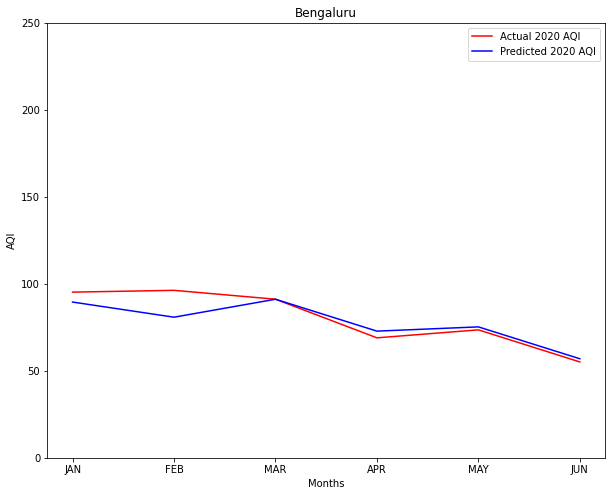

In [24]:
import matplotlib.pyplot as plt 

plt.figure(figsize = (10,8))


plt.plot(list_dates, lst_2020_original ,  color='red', label='Actual 2020 AQI') 
plt.plot(list_dates, lst_2020_graph,  color='blue', label='Predicted 2020 AQI') 
plt.ylim(0,250)
plt.xlabel('Months')  
plt.ylabel('AQI') 
plt.title('Bengaluru')
plt.legend() 
plt.show() 

In [22]:
stat, p = wilcoxon(lst_2020_graph, lst_2020_original)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=9.000, p=0.844
